In [1]:
from covid.simulator import Population
from covid.auxilliary import symptom_names
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from covid.policy import Policy

In [2]:

from scipy.stats import bernoulli, beta, uniform

In [3]:
genome_names = ['genome' + str(i) for i in range(128)]
comorbiditie_names = ['asthma', 'obesity', 'smoking', 'diabetes', 
    'heart_disease', 'hypertension']
vaccination_status_names = ['vaccine_1', 'vaccine_2', 'vaccine_3']
symptomNames = ['covid_recovered','covid_positive', 'no_taste_smell',
    'fever','headache', 'pneumonia','stomach','myocarditis', 'blood_clots','death']

feature_names = symptomNames + ['age', 'gender','income'] + genome_names + comorbiditie_names + vaccination_status_names

# Helper indexes
symptom_indexes = np.array(range(len(symptomNames)))
age_gender_income_indexes = np.array(range(len(symptomNames), len(symptomNames)+3))
genome_indexes = np.array(range(len(symptomNames) + 3, len(symptomNames) + 3 + len(genome_names)))
comorbiditie_indexes = np.array(range(len(symptomNames) + 3 + len(genome_names), 
    len(symptomNames)+3 + len(genome_names) + len(comorbiditie_names)))
print(symptom_indexes)
print(age_gender_income_indexes)
print(genome_indexes)
print(comorbiditie_indexes)



[0 1 2 3 4 5 6 7 8 9]
[10 11 12]
[ 13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30
  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140]
[141 142 143 144 145 146]


# Utility function weights

In [4]:
#covid_recovered, covid_positive, no_taste_smell, fever, headache, pneumonia, stomach, myocarditis, blood_clots, death
w = np.array([0, 0.2, 0.1, 0.1, 0.1, 0.5, 0.2, 0.5, 1.0, 100])
assert w.shape[0] == 10, 'Shape of weights does not fit number of symptoms'

In [5]:
class BetaBernoulliModel:
    def __init__(self, nsymptom, nvacc):
        # Priors for the beta-bernoulli model
        self.a = np.ones(shape=[nvacc, nsymptom])/2 # using jeffreys prior
        self.b = np.ones(shape=[nvacc, nsymptom])/2 # using jeffreys prior
        self.nvacc = nvacc
        self.nsymptom = nsymptom

    def update(self, features, actions, outcomes):
        """
        for index in range(self.nvacc):
            print(outcomes[np.where(actions == (index-1))]) 
            print(actions)
            print(outcomes)
            if (np.sum(outcomes[np.where(actions == index - 1)], axis=1).size != 0):
                self.a[index] += np.sum(outcomes[np.where(actions == index - 1)], axis=1)
                self.b[index] += np.sum(outcomes[np.where(actions == index - 1)]==0, axis=1)\
                    - np.sum(outcomes[np.where(actions == index - 1)], axis=1)
            else: 
                self.b[index] += np.sum((outcomes==0)[np.where(actions == index - 1)], axis=1)
        """

        # performing the update to the beta - Bernoulli model for each case
        # in a loop. i.e. when |y| = 1
        # TODO: vecotirze this / fix the code above
        for index, outcome in enumerate(outcomes):
            self.a[int(actions[index])] += outcome
            self.b[int(actions[index])] += 1 - outcome

    def get_params(self):
        # Returns the parameters of all the beta distrobutions.
        return self.a, self.b


    def get_prob(self, features, action):
        # Returns the maximum posterior estiamte / mean of the theta-distrobution
        # which is a/(a+b) where a and b are the posterior parameters
        return self.a[action] / (self.a[action] + self.b[action])

    
    def retrain(self, features, actions, outcomes):
        # Retrains the model using jeffreys prior. The input should be the complete 
        # database of the trials etc. (This overwrites the old model)
        # With no privacy guarantee, this is equivivalent to continously update the model
        # However if we add laplace noise, then this would be a centralized method
        # as opposed to the local method which 'update' employs

        self.a = np.ones(shape=[self.nvacc, self.nsymptom])/2 # using jeffreys prior
        self.b = np.ones(shape=[self.nvacc, self.nsymptom])/2 # using jeffreys prior

        self.update(features, actions, outcomes)
    
    def set_default_action(self, action):
        self.default_action = action
    
    def set_default_symptom(self, symptom):
        self.default_symptom = symptom

    def predict(self, X):
        probs = self.get_prob(X, self.default_action)[:,self.default_symptom]
        return (probs > 0.5).astype(int)


In [6]:
from sklearn.linear_model import LogisticRegression


# thompson model

In [7]:
class Thompson:
    def __init__(self, nsymptom, nvacc):
        # Priors for the beta-bernoulli model
        self.a = np.ones(shape=[nvacc, nsymptom]) # using flat prior
        self.b = np.ones(shape=[nvacc, nsymptom]) # using flat prior
        self.nvacc = nvacc
        self.nsymptom = nsymptom
    
    
    def update(self, features, actions, outcomes):
        for index, outcome in enumerate(outcomes):
            self.a[int(actions[index])] += outcome
            self.b[int(actions[index])] += 1 - outcome
    
    
    def set_default_action(self, action):
        self.default_action = action
    
    def set_default_symptom(self, symptom):
        self.default_symptom = symptom
    
    
    def get_params(self):
        # Returns the parameters of all the beta distrobutions.
        return self.a, self.b


    def get_prob(self, features, action):
        # Returns the maximum posterior estiamte / mean of the theta-distrobution
        # which is a/(a+b) where a and b are the posterior parameters
        return self.a[action] / (self.a[action] + self.b[action])
    
    def retrain(self, features, actions, outcomes):
        # Retrains the model using jeffreys prior. The input should be the complete 
        # database of the trials etc. (This overwrites the old model)
        # With no privacy guarantee, this is equivivalent to continously update the model
        # However if we add laplace noise, then this would be a centralized method
        # as opposed to the local method which 'update' employs

        self.a = np.ones(shape=[self.nvacc, self.nsymptom]) # using flat prior
        self.b = np.ones(shape=[self.nvacc, self.nsymptom]) # using flat prior

        self.update(features, actions, outcomes)


In [8]:
crit_symptom = ['pneumonia','myocarditis', 'blood_clots']

# new column where 1 if at least 1 critical symptom, 0 else

class Thompson_Pol(Policy):
    
    def set_model(self, model):
        # the model needs to have a get_prob function which returns the probabilities of
        # each induvidual symptom

        self.model = model
        
        
    def get_action(self, feature):
        """
        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.

        Returns:
        A t*|A| array of actions
        """
        #k = number of vaccines
        
        theta_hat = beta(alphas, betas).rvs(k)
        action = np.argmin(theta_hat, axis=1)
        r = feature
        

        

        

In [9]:
class Naive(Policy):
    def get_utility(self, features, action, outcome):
        utility = 0
        for t, o in enumerate(outcome):
            utility -= np.dot(w, o)*(1+int(action[t] != -1))
       
        return utility

    def set_model(self, model):
        # the model needs to have a get_prob function which returns the probabilities of
        # each induvidual symptom

        self.model = model
    
    def get_action(self, features):
        """Get a completely random set of actions, but only one for each individual.

        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.

        Returns:
        A t*|A| array of actions
        """
      
        
        n_obs = features.shape[0]
        actions = np.zeros(n_obs)
        
        for index, t in enumerate(features):
            u_list = []
            for a in self.action_set:
                u_list.append(self.get_expected_utility(a, t))
            actions[index] = np.argmax(np.array(u_list))
        return actions

    def get_expected_utility(self, action, features):
        p = self.model.get_prob(features, action)
        
        return -np.dot(p, w)*(1+int(action != -1))

    def observe(self, features, action, outcomes):
        self.model.update(features, action, outcomes)

        

In [10]:
## Baseline simulator parameters
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_000
n_symptoms = 10
#batch_size = 2000

#assert n_population/batch_size == n_population//batch_size, 'the batch size must evenly divide the number of people'


# symptom names for easy reference
from covid.auxilliary import symptom_names


population = Population(n_genes, n_vaccines, n_treatments)
X = population.generate(n_population)
n_features = X.shape[1]



<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
#Make neew column for critical symptom
new_col = X[:,[5,7,8]].sum(axis=1)
new_col0 = new_col > 0
new_col01 = new_col0.astype(int)
new_col01 = np.reshape(new_col01,(n_population,-1))
X_new = np.hstack((X,new_col01))


In [12]:
# These are the possbile actions, currently restricted to -1, which is
# No vaccine, and 0, which is a vaccine
action_space = np.array([-1,0,1,2])
nactions = action_space.shape[0]

# Initializing our policy with the number of actions and
vaccine_policy = Thompson_Pol(nactions, action_space)

# Here we set our predictive model
#vaccine_policy.set_model(LogisticModel(n_symptoms, nactions))
vaccine_policy.set_model((n_symptoms, nactions))

# Arrays to store the actions and outcomes for each
Y = np.zeros((n_population, n_symptoms))
A = np.zeros(n_population)


sims = 1000

alphas = np.ones((sims, nactions))
betas = np.ones((sims, nactions))

#alphas = np.ones(nactions)
#betas = np.ones(nactions)
actions_t = []
dists = []
idx = np.arange(sims)

for t in range(n_population):
    
    theta_hat = beta(alphas, betas).rvs((sims, nactions))
    #theta_hat = beta(alphas, betas).rvs(nactions)
    
    action = np.argmin(theta_hat, axis=1)
    r = X_new[t, 150]
    alphas[idx,action] += r
    betas[idx,action] += (1-r)
    
    y_t = population.vaccinate([t], action[1].reshape((1, 1)))
    
    actions_t.append(action)
    dists.append(beta(alphas.copy(), betas.copy()))
    #a,b = symptom after vaccine
    #feed back symptom to alpha and beta
    
    
    
    
    
"""   
    #print("Person nr: ", t)
    a_t = vaccine_policy.get_action(X[t].reshape((1, n_features)))
    # Then you can obtain results for everybody
    y_t = population.vaccinate([t], a_t.reshape((1, 1)))
    # Feed the results back in your policy. This allows you to fit the
    
    # statistical model you have.
    vaccine_policy.observe(X[t], a_t, y_t)
    
    # Saving action taken and outcome obtained.
    Y[t] = y_t
    A[t] = a_t
"""
ff=0
print(ff)

Initialising policy with  4 actions
A = { [-1  0  1  2] }
0


[[1 1 3 ... 2 1 0]
 [0 2 0 ... 1 3 2]
 [2 2 0 ... 3 3 3]
 ...
 [0 2 1 ... 0 2 1]
 [3 3 1 ... 0 2 3]
 [2 2 1 ... 0 2 2]]


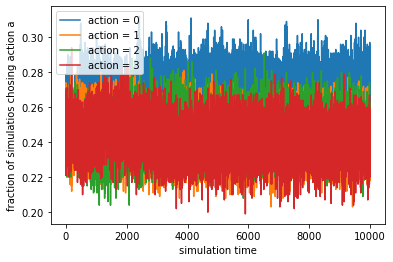

In [13]:
a_t = np.array(actions_t)

for a in range(4):
    plt.plot((a_t==a).mean(axis=1), label=f"action = {a}")
    #plt.hist(a_t, label=f"action = {a}")
plt.xlabel("simulation time")
plt.ylabel("fraction of simulatios chosing action a")
plt.legend()
print(a_t)

In [14]:
class NaiveWithTrial(Policy):
    def __init__(self, n_actions, action_set):
        super().__init__(n_actions, action_set)
        self.trials = -1

    def get_utility(self, features, action, outcome):
        utility = 0
        for t, o in enumerate(outcome):
            utility -= np.dot(w, o)*(1+int(action[t] != -1))
       
        return utility

    def set_model(self, model):
        self.model = model
    
    def get_action(self, features):
        """Get a completely random set of actions, but only one for each individual.

        If there is more than one individual, feature has dimensions t*x matrix, otherwise it is an x-size array.
        
        It assumes a finite set of actions.

        Returns:
        A t*|A| array of actions
        """
      
        
        n_obs = features.shape[0]
        actions = np.zeros(n_obs)
        
        if self.trials > 0:
            print('Random trial')
            self.trials -= n_obs
            for i in range(n_obs):
                actions[i] = np.random.choice(self.action_set)
            
            return actions

        for index, t in enumerate(features):
            u_list = []
            for a in self.action_set:
                u_list.append(self.get_expected_utility(a, t))
            actions[index] = np.argmax(np.array(u_list)) - 1
            print(u_list)
        return actions

    def get_expected_utility(self, action, features):
        p = self.model.get_prob(features, action)
        return -np.dot(p, w)*(1+int(action != -1))

    def observe(self, features, action, outcomes):
        self.model.update(features, action, outcomes)
    
    def set_trial(self, n_trials: int):
        # defines the size of the random trail at the beginning
        self.trials = n_trials
        
        

In [15]:
def privacy_tradeoff(epsilon, policy):
    # Returns the loss in uility given a privacy guarantee of epsilon
    # Either absolute or relative
    pass

In [16]:
## Baseline simulator parameters
n_genes = 128
n_vaccines = 3 # DO NOT CHANGE, breaks the simulator.
n_treatments = 4
n_population = 10_000
n_symptoms = 10
batch_size = 2000

assert n_population/batch_size == n_population//batch_size, 'the batch size must evenly divide the number of people'


# symptom names for easy reference
from covid.auxilliary import symptom_names

In [17]:
# Setting the population generator
population = Population(n_genes, n_vaccines, n_treatments)


In [18]:
X = population.generate(n_population)
n_features = X.shape[1]


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [19]:
import sklearn as sk
import warnings

from warnings import filterwarnings
filterwarnings('ignore')


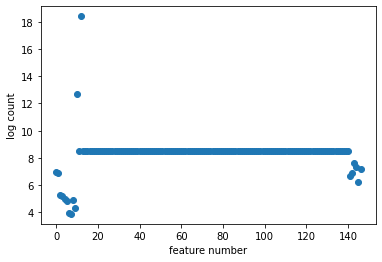

In [20]:
# Plotting data for some intution
plt.scatter(range(150),np.log(np.sum(X, axis=0)))
plt.ylabel('log count')
plt.xlabel('feature number')
None


# Running our policy in a loop
To test our policy, we can loop over every individual in the population 'X' and decide on the action and observe the outcome

In [21]:
# These are the possbile actions, currently restricted to -1, which is
# No vaccine, and 0, which is a vaccine
action_space = np.array([-1,0,1,2])
nactions = action_space.shape[0]

# Initializing our policy with the number of actions and
vaccine_policy = NaiveWithTrial(nactions, action_space)
vaccine_policy.set_trial(1999)

# Here we set our predictive model
#vaccine_policy.set_model(LogisticModel(n_symptoms, nactions))
vaccine_policy.set_model(BetaBernoulliModel(n_symptoms, nactions))

# Arrays to store the actions and outcomes for each
Y = np.zeros((n_population, n_symptoms))
A = np.zeros(n_population)

batch_size = 1

if batch_size == 1:
    for t in range(n_population):
        #print("Person nr: ", t)
        a_t = vaccine_policy.get_action(X[t].reshape((1, n_features)))
        # Then you can obtain results for everybody
        y_t = population.vaccinate([t], a_t.reshape((1, 1)))
        # Feed the results back in your policy. This allows you to fit the
        # statistical model you have.
        vaccine_policy.observe(X[t], a_t, y_t)
        
        
        print(a_t.reshape((1, 1)))
        # Saving action taken and outcome obtained.
        Y[t] = y_t
        A[t] = a_t
else:
    for b in range(n_population//batch_size):
        print("Batch nr: ", b)
        start = b*batch_size
        stop = (b+1) * batch_size
        indexes = np.arange(start, stop, step=1).astype(int)

        a = vaccine_policy.get_action(X[indexes]).astype(int)
        #print(a)
        # Then you can obtain results for everybody
        y = population.vaccinate(indexes, a.reshape(batch_size, 1))

        # Feed the results back in your policy. This allows you to fit the
        # statistical model you have.
        vaccine_policy.observe(X[indexes], a, y)

        # Saving action taken and outcome obtained.
        Y[indexes] = y
        A[indexes] = a



Initialising policy with  4 actions
A = { [-1  0  1  2] }
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[

[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Ran

[[0.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[1.]]


[[0.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[-1.]]

[[0.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[-1.]]
Random trial
[[-1.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[2.]]
Random trial
[[1.]]
Random trial
[[-1.]]
Random trial
[[0.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[0.]]
Random trial
[[1.]]
Random trial
[[2.]]
Random trial
[[0.]]
Random trial
[[0.]]
Rand

[[-1.]]
[-0.27391618497109826, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2738095238095238, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2737031700288184, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2735971223021582, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2734913793103448, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2733859397417504, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.27328080229226365, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.27317596566523605, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2730714285714286, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2729671897289586, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.27286324786324784, -0.605421686746988, -0.5994152046783626, -0.620950323974

[[-1.]]
[-0.2612574850299401, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2611842105263158, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2611111111111111, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2610381861575179, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.26096543504171643, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.26089285714285715, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.26082045184304403, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2607482185273159, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2606761565836299, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2606042654028436, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2605325443786982, -0.605421686746988, -0.5994152046783626, -0.6209503239740

[-0.2517712550607287, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.25171890798786656, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2516666666666666, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2516145307769929, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.25156249999999997, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2515105740181269, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2514587525150906, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.25140703517587937, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.25135542168674696, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2513039117352056, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.25125250501002006, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[

[[-1.]]
[-0.24714285714285714, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24709944751381216, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2470561177552898, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24701286764705888, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24696969696969698, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24692660550458717, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24688359303391386, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24684065934065935, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2467978042086002, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24675502742230349, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24671232876712332, -0.605421686746988, -0.5994152046783626, -0.6209503

[[-1.]]
[-0.2402439024390244, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2402122641509434, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24018067556952083, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.240149136577708, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24011764705882355, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.24008620689655172, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2400548159749413, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2400234741784038, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2399921813917123, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23996093750000003, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23992974238875878, -0.605421686746988, -0.5994152046783626, -0.620950323974

[[-1.]]
[-0.23552083333333332, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23549618320610688, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23547156726768378, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2354469854469855, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23542243767313023, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23539792387543254, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23537344398340249, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.235348997926745, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23532458563535916, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23530020703933752, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2352758620689655, -0.605421686746988, -0.5994152046783626, -0.620950323

[[-1.]]
[-0.23053731343283582, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23051909307875895, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23050089445438285, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23048271752085822, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23046456223942827, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23044642857142858, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23042831647828674, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23041022592152202, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2303921568627451, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23037410926365795, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.23035608308605343, -0.605421686746988, -0.5994152046783626, -0.620950

[[-1.]]
[-0.22898016997167137, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2289637599093998, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22894736842105265, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22893099547511314, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22891464104013567, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22889830508474576, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22888198757763975, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22886568848758465, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22884940778341792, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22883314543404737, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22881690140845068, -0.605421686746988, -0.5994152046783626, -0.620950

[[-1.]]
[-0.22675209205020921, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22673810768426558, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2267241379310345, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22671018276762403, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22669624217118997, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22668231611893588, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22666840458811263, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22665450755601876, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22664062499999998, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22662675689744924, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22661290322580643, -0.605421686746988, -0.5994152046783626, -0.620950

[-0.22447368421052635, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2244619799139168, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2244502868068834, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22443860487338746, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2244269340974212, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22441527446300719, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22440362595419847, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22439198855507866, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2243803622497617, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22436874702239162, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2243571428571429, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[

[[-1.]]
[-0.22300944669365724, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22299910071942447, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2229887640449438, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22297843665768197, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22296811854512802, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22295780969479356, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22294751009421265, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22293721973094174, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2229269385925594, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22291666666666668, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2229064039408867, -0.605421686746988, -0.5994152046783626, -0.62095032

[[-1.]]
[-0.22147355163727958, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22146454049517417, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2214555369127517, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22144654088050314, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2214375523889355, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22142857142857145, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22141959798994973, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.221410632063625, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22140167364016738, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2213927227101631, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22138377926421404, -0.605421686746988, -0.5994152046783626, -0.6209503239

[[-1.]]
[-0.22033797216699802, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22032988871224168, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22032181168057213, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2203137410643368, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2203056768558952, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22029761904761908, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22028956763189209, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22028152260111025, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22027348394768131, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22026545166402534, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.22025742574257426, -0.605421686746988, -0.5994152046783626, -0.6209503

[[-1.]]
[-0.21936766376372585, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21936033308099925, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21935300794551646, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21934568835098336, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21933837429111533, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2193310657596372, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21932376275028334, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21931646525679763, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21930917327293317, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21930188679245288, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21929460580912866, -0.605421686746988, -0.5994152046783626, -0.620950

[[-1.]]
[-0.21864746627779807, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21864067055393588, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21863387978142076, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2186270939548434, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21862031306880234, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21861353711790393, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21860676609676247, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21860000000000002, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21859323882224646, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21858648255813956, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21857973120232474, -0.605421686746988, -0.5994152046783626, -0.620950

[-0.21795366795366797, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21794736842105264, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21794107330761137, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21793478260869562, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21792849631966354, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21792221443587945, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21791593695271455, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21790966386554622, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2179033951697585, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21789713086074178, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21789087093389295, -0.605421686746988, -0.5994152046783626, -0.62095032397408

[-0.2172804054054054, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.217274569402229, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21726873733963542, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21726290921363484, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2172570850202429, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21725126475548065, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21724544841537427, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21723963599595553, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21723382749326148, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21722802290333446, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21722222222222223, -0.605421686746988, -0.5994152046783626, -0.620950323974082]


[[-1.]]
[-0.21667209908735333, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21666666666666667, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2166612377850163, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.216655812438945, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21665039062500002, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21664497233973315, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21663955757970074, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21663414634146347, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2166287386215865, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2166233344166396, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21661793372319688, -0.605421686746988, -0.5994152046783626, -0.6209503239

[-0.21597938144329898, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21597439100562152, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2159694036840462, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21596441947565542, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21595943837753506, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2159544603867748, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21594948550046772, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21594451371571072, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21593954502960425, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21593457943925232, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21592961694176271, -0.605421686746988, -0.5994152046783626, -0.620950323974082

[-0.21526410026857656, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21525954653937948, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21525499552639427, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21525044722719144, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21524590163934426, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21524135876042907, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21523681858802504, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21523228111971413, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21522774635308128, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21522321428571428, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2152186849152038, -0.605421686746988, -0.5994152046783626, -0.62095032397408

[[-1.]]
[-0.21434782608695652, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21434380257992153, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21433978132884776, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2143357623318386, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21433174558699916, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.214327731092437, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21432371884626156, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21431970884658452, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21431570109151976, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.214311695579183, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21430769230769228, -0.605421686746988, -0.5994152046783626, -0.6209503239

[[-1.]]
[-0.21392215568862274, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2139183673469388, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21391458106637648, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21391079684525427, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21390701468189233, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2139032345746127, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21389945652173917, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21389568052159738, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21389190657251492, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21388813467282108, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21388436482084694, -0.605421686746988, -0.5994152046783626, -0.6209503

[[-1.]]
[-0.21328916601714734, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21328571428571433, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21328226434692288, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21327881619937697, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2132753698416818, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21327192527244423, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2132684824902724, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21326504149377595, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21326160228156602, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21325816485225507, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21325472920445712, -0.605421686746988, -0.5994152046783626, -0.6209503

[[-1.]]
[-0.2129493670886076, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21294608959757022, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21294281376518218, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21293953959018466, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21293626707132018, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21293299620733253, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21292972699696663, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2129264594389689, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2129231935320869, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2129199292750695, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2129166666666667, -0.605421686746988, -0.5994152046783626, -0.6209503239

[[-1.]]
[-0.21261716822890972, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21261405672009862, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21261094674556213, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21260783830416569, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2126047313947758, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21260162601626018, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2125985221674877, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2125954198473283, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21259231905465292, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21258921978833376, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21258612204724414, -0.605421686746988, -0.5994152046783626, -0.62095032

[-0.21231046931407943, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21230750721847932, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2123045465479913, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21230158730158732, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21229862947824, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2122956730769231, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21229271809661138, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21228976453628065, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21228681239490754, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21228386167146973, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21228091236494598, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[

[[-1.]]
[-0.21192029829876485, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21191752096924513, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2119147449336129, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21191197019096414, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21190919674039585, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21190642458100561, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21190365371189204, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2119008841321545, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21189811584089324, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21189534883720934, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21189258312020462, -0.605421686746988, -0.5994152046783626, -0.6209503

[[-1.]]
[-0.21167008898015058, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2116674270072993, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2116647662485747, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21166210670314642, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21165944837018466, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21165679124886053, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21165413533834587, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2116514806378132, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2116488271464359, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.211646174863388, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2116435237878443, -0.605421686746988, -0.5994152046783626, -0.620950323974

[-0.2113970588235294, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2113945199376253, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21139198218262809, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21138944555778225, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21138691006233307, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21138437569552643, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21138184245660888, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21137931034482763, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21137677935943064, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21137424949966646, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2113717207647844, -0.605421686746988, -0.5994152046783626, -0.620950323974082]

[[-1.]]
[-0.21106903267690974, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21106663781912588, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21106424399740428, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21106185121107268, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21105945945945948, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21105706874189364, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2110546790577048, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.211052290406223, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.211049902786779, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2110475161987041, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21104513064133015, -0.605421686746988, -0.5994152046783626, -0.62095032397

[[-1.]]
[-0.2107661544937908, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2107638888888889, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2107616242373238, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21075936053849395, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2107570977917981, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21075483599663583, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21075257515240697, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.210750315258512, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21074805631435173, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21074579831932774, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2107435412728418, -0.605421686746988, -0.5994152046783626, -0.620950323974

[[-1.]]
[-0.2104923076923077, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2104901558654635, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21048800492105804, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2104858548585486, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2104837056773929, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21048155737704918, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21047940995697603, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21047726341663256, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2104751177554782, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21047297297297296, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21047082906857728, -0.605421686746988, -0.5994152046783626, -0.6209503239

[[-1.]]
[-0.21029589371980678, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21029382169450594, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21029175050301813, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21028968014484006, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21028761061946902, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21028554192640256, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21028347406513875, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2102814070351759, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2102793408360129, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2102772754671489, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2102752109280836, -0.605421686746988, -0.5994152046783626, -0.620950323

[[-1.]]
[-0.21009273875295978, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2100907476819886, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21008875739644967, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21008676789587852, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21008477917981075, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2100827912477824, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21008080409932994, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21007881773399012, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21007683215130027, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.21007484735079776, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2100728633320205, -0.605421686746988, -0.5994152046783626, -0.62095032

[-0.20985929067077871, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20985739063403352, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20985549132947978, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2098535927566943, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20985169491525424, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20984979780473714, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20984790142472085, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20984600577478346, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2098441108545035, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2098422166634597, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20984032320123125, -0.605421686746988, -0.5994152046783626, -0.620950323974082]

[-0.20962008651495204, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20961827754795037, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20961646926113933, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20961466165413536, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20961285472655516, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20961104847801582, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2096092429081345, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2096074380165289, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2096056338028169, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2096038302666166, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20960202740754652, -0.605421686746988, -0.5994152046783626, -0.620950323974082]


[[-1.]]
[-0.20943204868154158, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2094303097345133, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20942857142857144, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20942683376336155, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20942509673852958, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20942336035372147, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20942162460858355, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20941988950276244, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.209418155035905, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20941642120765833, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2094146880176698, -0.605421686746988, -0.5994152046783626, -0.620950323

[[-1.]]
[-0.20913066761870763, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20912903801534893, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20912740899357604, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20912578055307762, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20912415269354268, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20912252541466028, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20912089871611983, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.209119272597611, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20911764705882352, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20911602209944752, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20911439771917323, -0.605421686746988, -0.5994152046783626, -0.6209503

[[-1.]]
[-0.208976833976834, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20897525881733636, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20897368421052634, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20897211015611297, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2089705366538057, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20896896370331405, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20896739130434785, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20896581945661702, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20896424815983178, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2089626774137025, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20896110721793976, -0.605421686746988, -0.5994152046783626, -0.620950323

[-0.20869602176130567, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20869454360020398, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2086930659415364, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20869158878504673, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2086901121304791, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20868863597757775, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20868716032608695, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2086856851757514, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20868421052631578, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20868273637752507, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20868126272912424, -0.605421686746988, -0.5994152046783626, -0.620950323974082]

[[-1.]]
[-0.20842668863261943, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20842530060945477, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20842391304347826, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.208422525934464, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20842113928218636, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20841975308641977, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20841836734693878, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20841698206351822, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20841559723593284, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20841421286395787, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20841282894736846, -0.605421686746988, -0.5994152046783626, -0.6209503

[[-1.]]
[-0.20829011345218804, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20828877005347596, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20828742709008424, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2082860845618014, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20828474246841594, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2082834008097166, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20828205958549226, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2082807187955318, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2082793784396245, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2082780385175595, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20827669902912618, -0.605421686746988, -0.5994152046783626, -0.6209503239

[[-1.]]
[-0.2081487971961128, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20814749920356804, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20814620162446248, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20814490445859873, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20814360770577933, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2081423113658071, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20814101543848482, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20813971992361555, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2081384248210024, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20813713013044866, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20813583585175763, -0.605421686746988, -0.5994152046783626, -0.62095032

[-0.20798719550281072, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20798594847775176, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2079847018420231, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2079834555954425, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20798220973782774, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20798096426899673, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20797971918876754, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20797847449695836, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2079772301933874, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20797598627787311, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20797474275023387, -0.605421686746988, -0.5994152046783626, -0.620950323974082]

[[-1.]]
[-0.20786439114391145, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20786318216756342, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20786197356286504, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20786076532964498, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20785955746773208, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.207858349976955, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2078571428571429, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2078559361081247, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20785472972972974, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2078535237217872, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2078523180841265, -0.605421686746988, -0.5994152046783626, -0.62095032397

[[-1.]]
[-0.20775352432924057, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20775234919672625, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20775117442036675, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20775, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20774882593546432, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20774765222659802, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2077464788732394, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20774530587522713, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2077441332323997, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2077429609445958, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2077417890116543, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1

[[-1.]]
[-0.2075946547884187, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2075935273159145, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20759240017812086, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2075912733748887, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20759014690606914, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2075890207715134, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20758789497107255, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20758676950459803, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20758564437194127, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20758451957295374, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20758339510748705, -0.605421686746988, -0.5994152046783626, -0.620950323

[[-1.]]
[-0.20746933411214952, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2074682435392028, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20746715328467152, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2074660633484163, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2074649737302977, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20746388443017655, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20746279544791366, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2074617067833698, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20746061843640606, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20745953040688347, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20745844269466318, -0.605421686746988, -0.5994152046783626, -0.620950323

[[-1.]]
[-0.20736183074265974, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2073607713340049, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20735971223021585, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.207358653431161, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20735759493670886, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20735653674672805, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20735547886108716, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20735442127965495, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20735336400230017, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2073523070288918, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20735125035929863, -0.605421686746988, -0.5994152046783626, -0.620950323

[[-1.]]
[-0.20723479490806224, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20723377174374205, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2072327488687783, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20723172628304823, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2072307039864292, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20722968197879857, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20722866026003392, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20722763883001272, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20722661768861259, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2072255968357113, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20722457627118643, -0.605421686746988, -0.5994152046783626, -0.62095032

[[-1.]]
[-0.20712792642140468, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20712693325902187, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20712594037336307, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2071249477643126, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20712395543175488, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20712296337557445, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20712197159565582, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20712098009188362, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20711998886414254, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20711899791231736, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20711800723629278, -0.605421686746988, -0.5994152046783626, -0.620950

[[-1.]]
[-0.20697341513292436, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20697246455834242, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2069715142428786, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20697056418642681, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20696961438888134, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20696866485013624, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20696771557008586, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20696676654862436, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2069658177856462, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2069648692810458, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2069639210347175, -0.605421686746988, -0.5994152046783626, -0.620950323

[[-1.]]
[-0.2068364073777065, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20683549378591473, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2068345804382683, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20683366733466935, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20683275447502006, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20683184185922265, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20683092948717954, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2068300173587929, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2068291054739653, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20682819383259912, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20682728243459694, -0.605421686746988, -0.5994152046783626, -0.620950323

[-0.2067426838913789, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20674179517595886, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20674090669478126, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20674001844775333, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20673913043478262, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20673824265577662, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20673735511064278, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2067364677992888, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20673558072162235, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.206734693877551, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20673380726698262, -0.605421686746988, -0.5994152046783626, -0.620950323974082]


[[-1.]]
[-0.20662822340287676, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20662736460222858, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2066265060240964, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20662564766839378, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20662478953503433, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2066239316239316, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20662307393499937, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2066222164681512, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.206621359223301, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2066205022003624, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20661964539924937, -0.605421686746988, -0.5994152046783626, -0.62095032397

[[-1.]]
[-0.20647714321894392, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20647632311977712, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20647550322825672, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20647468354430384, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20647386406783955, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20647304479878514, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20647222573706187, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20647140688259114, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2064705882352941, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20646976979509235, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20646895156190717, -0.605421686746988, -0.5994152046783626, -0.620950

[-0.20630236569738786, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20630158925711473, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2063008130081301, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20630003695036336, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20629926108374383, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20629848540820098, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2062977099236641, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20629693463006282, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20629615952732644, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2062953846153846, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20629460989416687, -0.605421686746988, -0.5994152046783626, -0.620950323974082]

[[-1.]]
[-0.20614414414414417, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20614340619745378, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2061426684280053, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2061419308357349, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2061411934205787, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.206140456182473, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20613971912135398, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20613898223715793, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20613824552982124, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20613750899928004, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20613677264547092, -0.605421686746988, -0.5994152046783626, -0.6209503239

[-0.20602260685270218, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.206021897810219, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20602118893466745, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20602048022598876, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20601977168412383, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.2060190633090139, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20601835510060007, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20601764705882356, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20601693918362546, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20601623147494708, -0.605421686746988, -0.5994152046783626, -0.620950323974082]
[[-1.]]
[-0.20601552393272965, -0.605421686746988, -0.5994152046783626, -0.620950323974082]

In [22]:
population.NUMBEROFVACCINATED

1471

Accumulated utility for the policy run: -2294.2000000000676
Average utility for the policy run: -0.22942000000000676


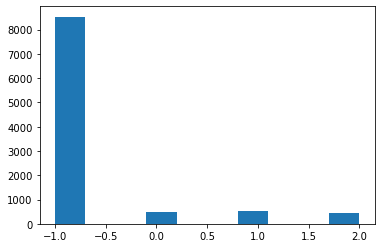

In [23]:
plt.hist(A)

#plt.scatter(range(150),np.sum(X, axis=0))
print('Accumulated utility for the policy run:', vaccine_policy.get_utility(X, A, Y))
print('Average utility for the policy run:', vaccine_policy.get_utility(X, A, Y)/n_population)

# Fairness

(10000,)


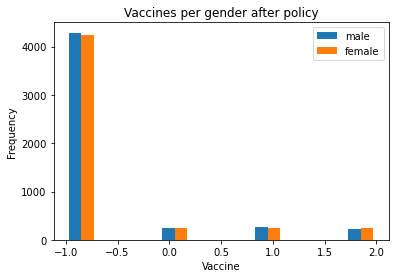

In [24]:
print(A.shape)

mm = np.where(X[:,11]==1) #male
ff = np.where(X[:,11]==0) #female

m_a = np.take(A, mm)
m_a = m_a.flatten()

f_a = np.take(A, ff)
f_a = f_a.flatten()

plt.hist([m_a, f_a],label=['male','female'])
plt.xlabel('Vaccine')
plt.ylabel('Frequency')
plt.title('Vaccines per gender after policy')
plt.legend(loc='upper right')
plt.show()


In [25]:
def print_pre_statistics(X):
    print(f'Statistic (N={X.shape[0]})')
    for i in range(len(symptom_names)-1):
        print(f'{symptom_names[i].ljust(15)} {X[:, i].sum()}')


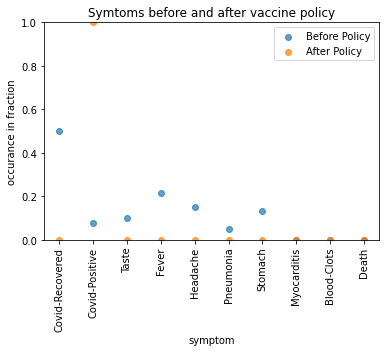

In [26]:
def plot_symptom_occurence(symptoms, label=None, ylim=[0,1],title=None):
    plt.scatter(range(n_symptoms), symptoms.sum(axis=0)/symptoms.shape[0], label=label, alpha=0.7)
    plt.xticks(range(n_symptoms), labels=symptom_names, rotation=90)
    plt.ylabel('occurance in fraction')
    plt.xlabel('symptom')
    if ylim is not None:
        plt.ylim(ylim)
    if title is not None:
        plt.title(title)



plot_symptom_occurence(X[:, -10:], label='Before Policy')
plot_symptom_occurence(Y, label='After Policy', title='Symtoms before and after vaccine policy')
plt.legend()
None

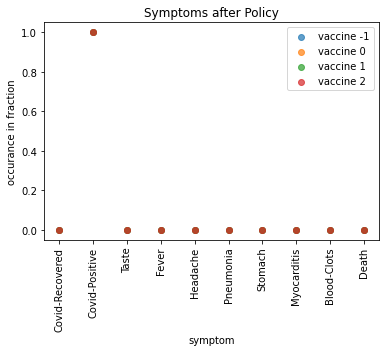

In [27]:
def plot_symptom_occurence_vaccine(symptoms, actions, label=None):

    for a in action_space:
        s = symptoms[np.where(actions == a)]
        plot_symptom_occurence(s, label=f'vaccine {a}', ylim=None)
        plt.title('Symptoms after Policy')
    plt.legend()
    
plot_symptom_occurence_vaccine(Y, A)

In [28]:
# Getting model paramters and plotting expectation

a, b = vaccine_policy.model.get_params()
c = a[0]/(a[0] + b[0])
v = a[1]/(a[1] + b[1])


In [29]:
print('NO VACCINE:')
for index, val in enumerate(c):
    print(f'{symptomNames[index].ljust(18)}{val:.6f}')

NO VACCINE:
covid_recovered   0.001004
covid_positive    0.998996
no_taste_smell    0.001004
fever             0.001004
headache          0.001004
pneumonia         0.001004
stomach           0.001004
myocarditis       0.001004
blood_clots       0.001004
death             0.001004


In [30]:
print('VACCINE:')
for index, val in enumerate(v):
    print(f'{symptomNames[index].ljust(18)}{val:.6f}')
    

VACCINE:
covid_recovered   0.000975
covid_positive    0.999025
no_taste_smell    0.000975
fever             0.000975
headache          0.000975
pneumonia         0.000975
stomach           0.000975
myocarditis       0.000975
blood_clots       0.000975
death             0.000975


In [31]:
print(np.mean(Y, axis=0))

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [32]:
print(np.sum(Y, axis=0))
#plt.scatter(range(150),np.sum(X, axis=0))
print('Accumulated utility for the policy run:', vaccine_policy.get_utility(X, A, Y))



[    0. 10000.     0.     0.     0.     0.     0.     0.     0.     0.]
Accumulated utility for the policy run: -2294.2000000000676


In [33]:
all1 = np.ones(shape=[X.shape[1]])
all0 = np.zeros(shape=[X.shape[1]])

m = vaccine_policy.model
for i in range(len(m.models)):
    for j in range(len(m.models[0])):
        print(m.models[i][j].predict_proba(all0.reshape(1, -1))[0,0])


AttributeError: 'BetaBernoulliModel' object has no attribute 'models'

# FAIRNESS
Assume we have a set of features $X$, a set of actions taken $A$, and a set of outcomes $Y$. Make a function that accepts these numpy arrays and calculates the equal-op score using this list of sensitive variables.


In [ ]:
sensitive_control_variables = ['gender', 'income']

In [ ]:
def equal_op(X, A, Y, Z=sensitive_control_variables):
    scores = np.zeros(len(Z))

    for z in Z:
        pass


    return scores
